# Predicting flood occurrence
Flood occurrences in downtown Norfolk are predicted based on rain, tide levels, water table levels, and wind speed/direction. 

In [1]:
repo = "http://cran.us.r-project.org"
library(caret)
library(ggfortify)
library(ggplot2)
library(dplyr)
library(rpart)
library(rpart.plot)
library(RSQLite)
library(DBI)
library(randomForest)
library(e1071)
library(class)

Warning message:
"package 'caret' was built under R version 3.3.3"Loading required package: lattice
Loading required package: ggplot2
Warning message:
"package 'ggplot2' was built under R version 3.3.3"Warning message:
"package 'ggfortify' was built under R version 3.3.3"Warning message:
"package 'dplyr' was built under R version 3.3.3"
Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Warning message:
"package 'rpart.plot' was built under R version 3.3.3"Warning message:
"package 'RSQLite' was built under R version 3.3.3"Warning message:
"package 'DBI' was built under R version 3.3.3"Warning message:
"package 'randomForest' was built under R version 3.3.3"randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.

Attaching package: 'randomForest'

The following object is masked from 'package:dplyr':

    combine

The followin

In [2]:
classify_knn = function(pca.data, obs_data, point, k){
  neighs = get_nn(pca.data, point, k)
  neigh_data = obs_data[neighs,]
  return(names(which.max(table(neigh_data$fld))))
}

In [3]:
get_nn = function(d, point, k){
  point = d[point, ]
  dists = sort(sqrt(rowSums((t(t(d) - point))^2)))
  close_points = names(dists)[2:k]
  return(close_points)
}

In [4]:
base_dir<- "C:/Users/Jeff/Documents/research/Sadler_3rdPaper/manuscript/"
data_dir<- "C:/Users/Jeff/Google Drive/research/Sadler_3rdPaper_Data/"
fig_dir <- paste(base_dir, "Figures/general/", sep="")
db_filename <- "floodData.sqlite"

In [5]:
con = dbConnect(RSQLite::SQLite(), dbname=paste(data_dir, db_filename, sep=""))

In [19]:
df = dbReadTable(con, 'for_model_geog')

In [20]:
df = df[df$is_dntn == 1,]
df = subset(df, rain_daily_sum>0.1)

In [21]:
colnames(df)

[1] "level_0"                 "Date"                   
 [3] "Condition"               "Horizontal"             
 [5] "Invert_Ele"              "Pipe_Geome"             
 [7] "Pipe_Lengt"              "Pipe_Mater"             
 [9] "Rim_Elevat"              "Structure1"             
[11] "Vertical_D"              "Year_Ins_1"             
[13] "Year_Insta"              "count"                  
[15] "dist_to_ba"              "dist_to_wa"             
[17] "elev_1"                  "event_name"             
[19] "flooded"                 "gw_daily_avg"           
[21] "imp"                     "index"                  
[23] "is_dntn"                 "location"               
[25] "num_flooded"             "rain_15_min_max"        
[27] "rain_15_min_max_time"    "rain_daily_sum"         
[29] "rain_hourly_max"         "rain_hourly_max_time"   
[31] "rain_prev_3_days"        "tide_daily_avg"         
[33] "tide_r15mx"              "tide_rhrmx"             
[35] "twi"                     "wind_dir_daily_avg"     
[37] "wind_vel_daily_avg"      "wind_vel_hourly_max_avg"
[39] "xcoord"                  "ycoord"

In [61]:
in_col_names = c('rain_daily_sum',
                 'rain_hourly_max',
                 'rain_15_min_max', 
                 'rain_prev_3_days', 
                 'gw_daily_avg', 
                 'tide_daily_avg', 
                 'wind_vel_daily_avg',
                 'tide_r15mx', 
                 'tide_rhrmx',
                 'imp',
                 'twi',
                 'dist_to_wa',
                 'dist_to_ba',
                 'Pipe_Geome',
                 'Horizontal',
                 'Invert_Ele',
                 'Vertical_D',
                 'Year_Insta',
                 'Pipe_Lengt',
                 'Rim_Elevat',
                 'Structure1',
                 'Year_Ins_1',
                 'Year_Insta',
                 'elev_1'
                )
out_col_name = 'flooded'
model_data = df[, c(in_col_names, out_col_name)]
model_data[,out_col_name] = model_data[,out_col_name]>0
model_data[,out_col_name] = factor(model_data[,out_col_name])

In [62]:
col_nums = c("twi", "dist_to_wa", "dist_to_ba", "Horizontal", "Invert_Ele", "Vertical_D", "Pipe_Lengt", "Rim_Elevat", "elev_1")
model_data[col_nums] = sapply(model_data[col_nums], as.numeric)
model_data$Structure1 = as.factor(model_data$Structure1)
model_data$Pipe_Geome = as.factor(model_data$Structure1)
model_data$Pipe_Mater = as.factor(model_data$Structure1)
str(model_data)

'data.frame':	179165 obs. of  26 variables:
 $ rain_daily_sum    : num  0.81 0.355 1.345 0.355 0.145 ...
 $ rain_hourly_max   : num  0.28 0.1 0.91 0.09 0.09 ...
 $ rain_15_min_max   : num  0.25 0.03 0.43 0.03 0.03 0.08 0.16 0.21 0.09 0.08 ...
 $ rain_prev_3_days  : num  0.81 0.44 1.345 0.355 0.53 ...
 $ gw_daily_avg      : num  2.41 2.93 3.45 2.85 3.07 ...
 $ tide_daily_avg    : num  0.2053 0.8775 0.5378 0.574 -0.0115 ...
 $ wind_vel_daily_avg: num  8.3 11.6 16.2 21.4 3 ...
 $ tide_r15mx        : num  -0.505 0.003 0.249 -0.469 0.154 ...
 $ tide_rhrmx        : num  0.246 0.269 0.036 -0.469 0.154 ...
 $ imp               : int  134205 134205 134205 134205 134205 134205 134205 134205 134205 134205 ...
 $ twi               : num  4.52 4.52 4.52 4.52 4.52 ...
 $ dist_to_wa        : num  3062 3062 3062 3062 3062 ...
 $ dist_to_ba        : num  90.6 90.6 90.6 90.6 90.6 ...
 $ Pipe_Geome        : Factor w/ 11 levels "CB","CBCS","CBCW",..: 5 5 5 5 5 5 5 5 5 5 ...
 $ Horizontal        : num  9 9

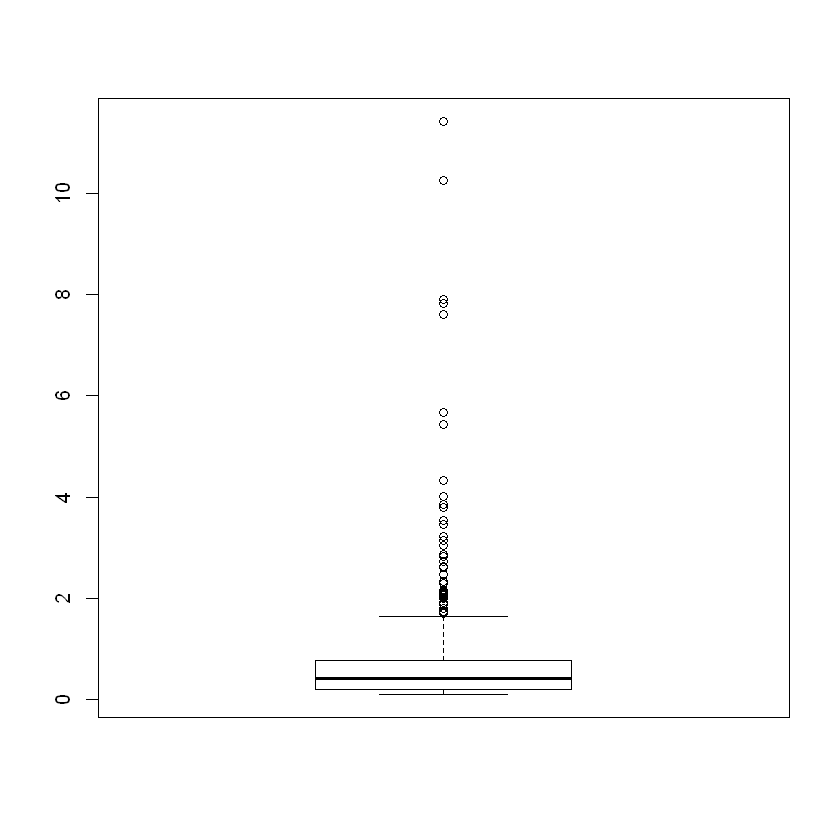

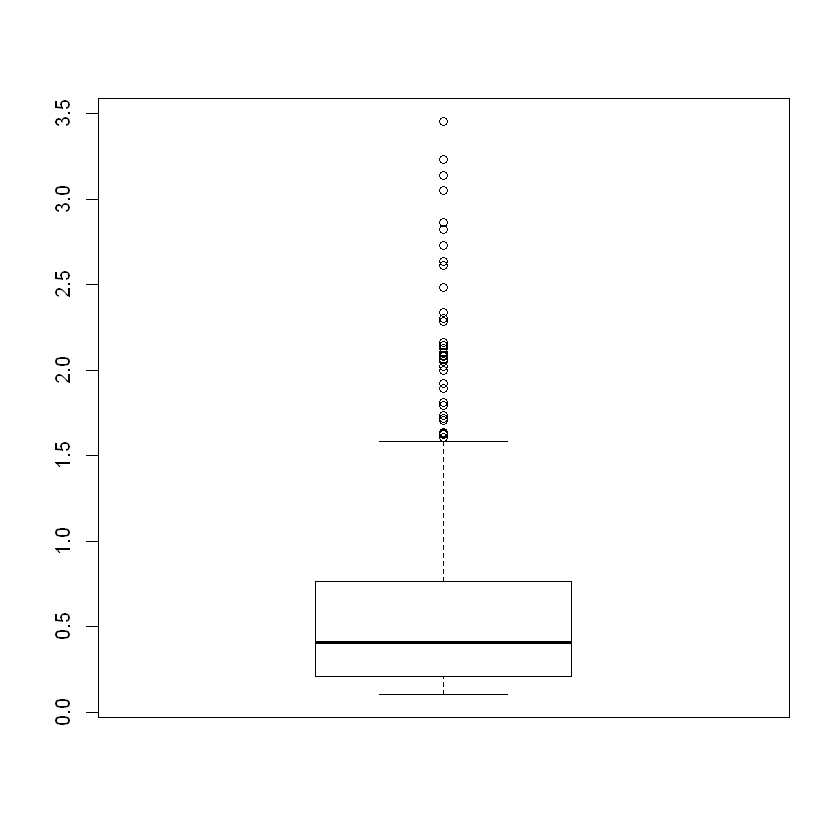

In [63]:
boxplot(model_data$rain_daily_sum)
median_fld_dly_rain = quantile(model_data[model_data$flooded == TRUE, 'rain_daily_sum'], .25)
hi_rn_rows = which(model_data$rain_daily_sum>median_fld_dly_rain)
model_data = model_data[-hi_rn_rows,]
boxplot(model_data$rain_daily_sum)

In [64]:
head(model_data[order(-model_data$rain_daily_sum),])

,rain_daily_sum,rain_hourly_max,rain_15_min_max,rain_prev_3_days,gw_daily_avg,tide_daily_avg,wind_vel_daily_avg,tide_r15mx,tide_rhrmx,imp,...,Vertical_D,Year_Insta,Pipe_Lengt,Rim_Elevat,Structure1,Year_Ins_1,Year_Insta.1,elev_1,flooded,Pipe_Mater
2618767,3.455,0.87,0.33,0.455,1.65029,2.149052,25.10297,3.304,1.759,136405,...,0,1929,5.00000,5.90,CBNS,1929,1929,1.91625,TRUE,CBNS
2845642,3.455,0.87,0.33,0.455,1.65029,2.149052,25.10297,3.304,1.759,105967,...,0,1965,32.93293,4.69,CBNS,0,1965,1.07764,TRUE,CBNS
2873093,3.455,0.87,0.33,0.455,1.65029,2.149052,25.10297,3.304,1.759,116098,...,0,0,43.18606,0.00,CB,0,0,1.95300,TRUE,CB
2875587,3.455,0.87,0.33,0.455,1.65029,2.149052,25.10297,3.304,1.759,131435,...,0,1943,0.00000,4.96,CBNS,0,1943,1.27146,TRUE,CBNS
2880566,3.455,0.87,0.33,0.455,1.65029,2.149052,25.10297,3.304,1.759,156326,...,0,1920,50.00000,5.97,CBNS,1920,1920,1.70476,TRUE,CBNS
2883052,3.455,0.87,0.33,0.455,1.65029,2.149052,25.10297,3.304,1.759,120275,...,0,1922,30.00000,8.98,CBDN,1922,1922,2.29492,TRUE,CBDN


In [65]:
print(summary(model_data$flooded))
sum(as.numeric(model_data$flooded == TRUE))/sum(as.numeric(model_data$flooded == FALSE))

 FALSE   TRUE 
176607    117 


[1] 0.0006624879

### Partition data into training and testing sets

In [66]:
prt = createDataPartition(model_data[, out_col_name], p=0.7)
train_ind = prt$Resample1
test_ind = rownames(model_data[-train_ind,])
print(length(test_ind) + length(train_ind))
# length(rownames(model_data[model_data[train_ind, out_col_name]==TRUE]))
length(test_ind)

[1] 176724


[1] 53017

In [67]:
train_data = model_data[train_ind, ]
test_data = model_data[test_ind, ]

### Downsample negative records in training dataset

In [68]:
nfld_train = rownames(train_data[train_data[, out_col_name] == FALSE,])
fld_train = rownames(train_data[train_data[, out_col_name] == TRUE,])
nfld_test = rownames(test_data[test_data[, out_col_name] == FALSE,])
fld_test = rownames(test_data[test_data[, out_col_name] == TRUE,])
down_sample_percent = .006
nfld_train_dwnsmp = sample(nfld_train, down_sample_percent*length(nfld_train))
train_ind = c(fld_train, nfld_train_dwnsmp)

In [69]:
train_in_data = model_data[train_ind, in_col_names]
test_in_data = model_data[test_ind, in_col_names]

In [70]:
tst_out = model_data[test_ind, out_col_name]
trn_out = model_data[train_ind, out_col_name]

### Scale data

In [18]:
train_col_stds = apply(train_in_data, 2, sd)
train_col_means = colMeans(train_in_data)

Warning message in var(if (is.vector(x) || is.factor(x)) x else as.double(x), na.rm = na.rm):
"NAs introduced by coercion"Warning message in var(if (is.vector(x) || is.factor(x)) x else as.double(x), na.rm = na.rm):
"NAs introduced by coercion"

ERROR: Error in colMeans(train_in_data): 'x' must be numeric


In [ ]:
train_normalized = t((t(train_in_data)-train_col_means)/train_col_stds)
test_normalized = t((t(test_in_data)-train_col_means)/train_col_stds)

### PCA transform

In [ ]:
pca = prcomp(train_normalized)
pca$x = -pca$x
pca$rotation=-pca$rotation
p = ggplot(pca$x[,c(1,2)], aes(x=PC1, y=PC2, colour=model_data[train_ind, out_col_name], label=rownames(pca$x)))
p + geom_point() + geom_text()
print(pca)
plot(pca)

In [ ]:
trn_preprocessed = predict(pca, train_normalized)
tst_preprocessed = predict(pca, test_normalized)
trn_in = trn_preprocessed
tst_in = tst_preprocessed

In [ ]:
train_data = cbind(as.data.frame(trn_in), flooded = model_data[train_ind, out_col_name])
fmla = as.formula(paste(out_col_name, "~", paste(colnames(trn_in), collapse="+")))
fmla

### KNN

In [ ]:
kfit = knn(trn_in, tst_in, trn_out, k=5)
table(tst_out, kfit)

### SVM

In [ ]:
svm_fit = svm(fmla, data=train_data)
svm_pred = predict(svm_fit, tst_in)
table(tst_out, svm_pred)

### Decision Trees

In [71]:
dt_fmla = as.formula(paste(out_col_name, "~", paste(in_col_names, collapse="+")))
dt_train_data = model_data[train_ind, ]
dt_test_data = model_data[test_ind, in_col_names]

In [72]:
colnames(dt_train_data)

[1] "rain_daily_sum"     "rain_hourly_max"    "rain_15_min_max"   
 [4] "rain_prev_3_days"   "gw_daily_avg"       "tide_daily_avg"    
 [7] "wind_vel_daily_avg" "tide_r15mx"         "tide_rhrmx"        
[10] "imp"                "twi"                "dist_to_wa"        
[13] "dist_to_ba"         "Pipe_Geome"         "Horizontal"        
[16] "Invert_Ele"         "Vertical_D"         "Year_Insta"        
[19] "Pipe_Lengt"         "Rim_Elevat"         "Structure1"        
[22] "Year_Ins_1"         "Year_Insta.1"       "elev_1"            
[25] "flooded"            "Pipe_Mater"

In [73]:
fit = rpart(dt_fmla, method='class', data=dt_train_data, minsplit=2)
printcp(fit)


Classification tree:
rpart(formula = dt_fmla, data = dt_train_data, method = "class", 
    minsplit = 2)

Variables actually used in tree construction:
[1] gw_daily_avg     imp              rain_daily_sum   rain_prev_3_days
[5] tide_rhrmx      

Root node error: 82/823 = 0.099635

n= 823 

        CP nsplit rel error  xerror     xstd
1 0.365854      0   1.00000 1.00000 0.104786
2 0.219512      1   0.63415 0.64634 0.085876
3 0.097561      2   0.41463 0.42683 0.070597
4 0.073171      3   0.31707 0.36585 0.065567
5 0.036585      4   0.24390 0.25610 0.055167
6 0.012195      5   0.20732 0.25610 0.055167
7 0.010000      7   0.18293 0.25610 0.055167


png 
  2

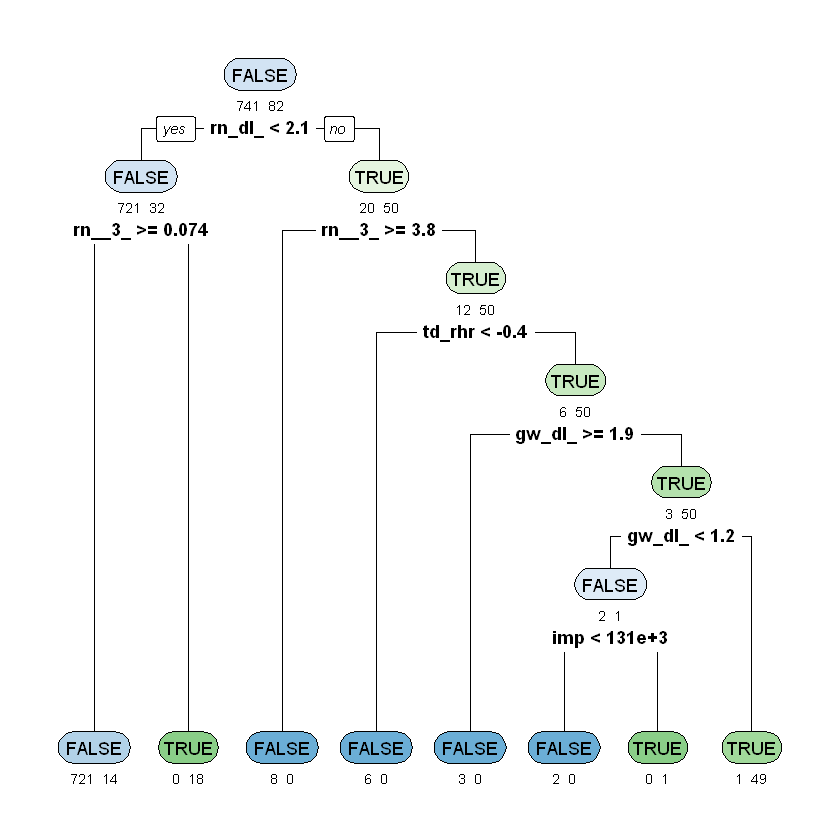

In [74]:
tiff(paste(fig_dir, "Plot2.tif"), width=9, height=6, units='in', res = 300)
rpart.plot(fit, under=TRUE, cex=0.9, extra=1, varlen = 6)
dev.off()
rpart.plot(fit, under=TRUE, cex=0.9, extra=1, varlen = 6)

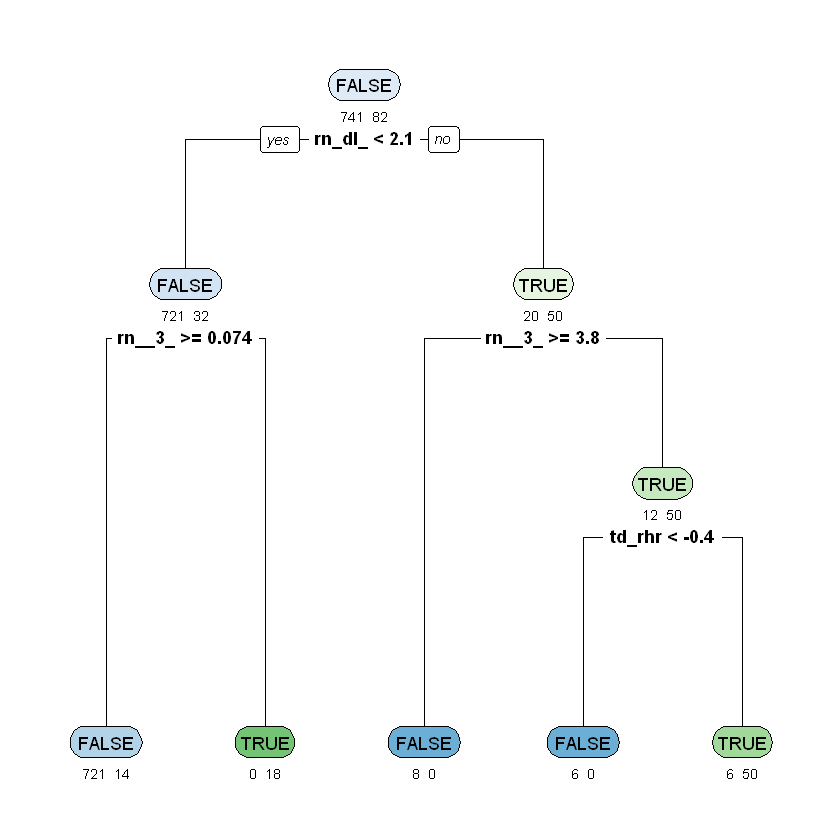

In [75]:
pfit<- prune(fit, cp=fit$cptable[which.min(fit$cptable[,"xerror"]),"CP"])
rpart.plot(pfit, under=TRUE, cex=0.9, extra=1, varlen = 6)

#### Decision Tree training results

In [76]:
pred = predict(pfit, dt_train_data[, in_col_names], type = 'class')
table(trn_out, pred)

       pred
trn_out FALSE TRUE
  FALSE   735    6
  TRUE     14   68

#### Decision Tree testing results

In [77]:
pred = predict(pfit, dt_test_data, type = 'class')
table(tst_out, pred)

       pred
tst_out FALSE  TRUE
  FALSE 52218   764
  TRUE     11    24

### Random Forests

In [78]:
forest = randomForest(dt_fmla, data = dt_train_data, importance = TRUE, type="classification", nodesize=2)

pred = predict(forest, dt_train_data[, in_col_names])
table(trn_out, pred)

       pred
trn_out FALSE TRUE
  FALSE   741    0
  TRUE      0   82

       pred
tst_out FALSE  TRUE
  FALSE 52476   506
  TRUE      8    27

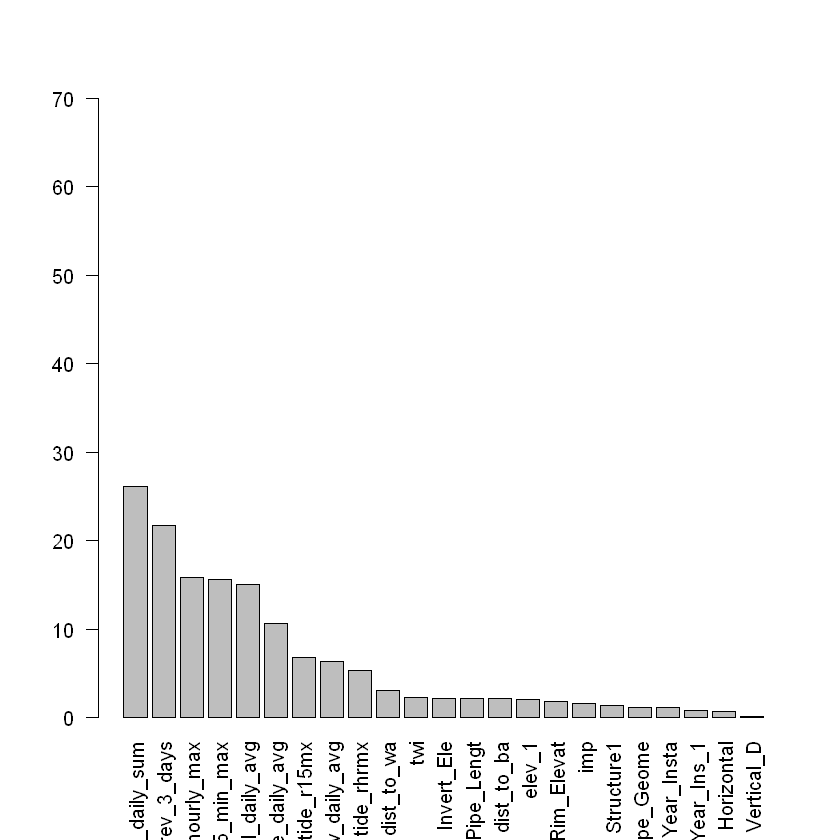

In [79]:
pred = predict(forest, dt_test_data)
table(tst_out, pred)
impo = as.data.frame(forest$importance)
impo = impo[order(-impo$MeanDecreaseGini),]
par(las=2)
barplot(impo$MeanDecreaseGini, names.arg=rownames(impo), ylim = c(0, 70))

### Logistic Regression

In [ ]:
lo_fit = glm(fmla, family=binomial(link='logit'), data=train_data)
print(lo_fit)

In [ ]:
pred = predict(lo_fit, as.data.frame(tst_in), type="response")
table(tst_out, round(pred)>0)